# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labelled training set of images, apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Train a classifier Linear SVM classifier.
2. Normalise your features and randomise a selection for training and testing.
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labelled training set of images, Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Train a Linear SVM classifier.

In [9]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

### Plot a sample each from vehicle and non-vehicle categories.

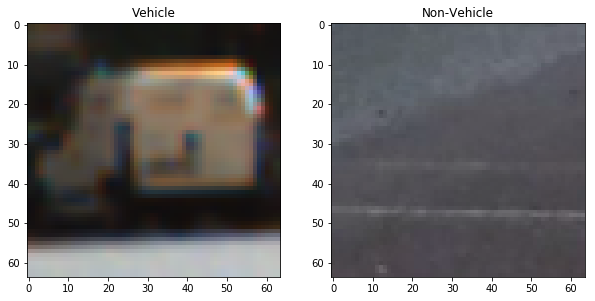

Car Images: 8792
Non Car Images: 8968


In [10]:
# List vehicles and Non-vehicle images
vehicle_images = glob.glob('train_data/vehicles/**/*.png')
non_vehicle_images = glob.glob('train_data/non-vehicles/**/*.png')

# Pick a random index
index = np.random.randint(0,high=8000)

vehicle = vehicle_images[index]
non_vehicle = non_vehicle_images[index]

# Plot a sample from vehicle and Non-Vehicle dataset
fig, axes = plt.subplots(ncols=2, figsize=(10, 8))
axes[0].imshow(cv2.imread(vehicle))
axes[0].set_title('Vehicle')
axes[1].imshow(cv2.imread(non_vehicle))
axes[1].set_title('Non-Vehicle')
plt.show()
print('Car Images: {}'.format(len(vehicle_images)))
print('Non Car Images: {}'.format(len(non_vehicle_images)))

### Spatial binned features

In [11]:
def get_spatial_bin_features(img, size=(32, 32)):
    # convert to feature vec
    features = cv2.resize(img, size).ravel() 
    return features

### Color Histogram Features

In [12]:
def get_color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### HOG Features

In [13]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if visualize==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Initial parametrers

In [14]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
size = (16,16)
hist_bins = 24
window = (64,64)
overlap = (0.5,0.5)

### Plot a sample image from Vehicle and Non-Vehicle dataset and it's respective HOG features

(<matplotlib.image.AxesImage at 0x7f69f3f77128>,
 <matplotlib.text.Text at 0x7f69f3fcb0f0>)

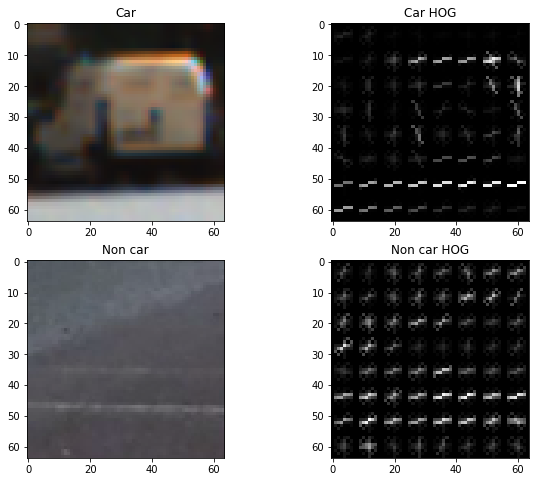

In [15]:
# Get a vehicle sample
car = cv2.imread(vehicle_images[index])
# Get hog features
_, car_hog = get_hog_features(car[:,:,2], 9, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,vis=True)
# Get a non vehicle sample
non_car = cv2.imread(non_vehicle_images[index])
# Get hog features
_, non_car_hog = get_hog_features(non_car[:,:,2], 9, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,vis=True)
# Plot both the samples and their respective HOG features
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
ax1.imshow(car), ax1.set_title('Car')
ax2.imshow(car_hog, cmap='gray'), ax2.set_title('Car HOG')
ax3.imshow(non_car), ax3.set_title('Non car')
ax4.imshow(non_car_hog, cmap='gray'), ax4.set_title('Non car HOG')

### Extract Spatial binned features, color histogram features and HOG features.

In [8]:
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        # spatial binning
        if spatial_feat == True:
            spatial_features = get_spatial_bin_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # Apply color_hist()
        if hist_feat == True:
            hist_features = get_color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 2. Normalise your features and randomise a selection for training and testing.

### Extract all features, Standardize and Split the data

Run this block on aws only. Requires at least 4GB RAM available for processing. (Disabling it so we don't run it by mistake)

### Dump the dataset in a pickle file so you can use it on a local machine
Run this block only on aws. (Disabling it so we don't run it by mistake)

### Build an SVC model, train and compute accuracy

In [18]:
def model(X_train, y_train, X_test, y_test):
    # Define a Linear SVC model
    svc = LinearSVC()
    # Fit the training set
    svc.fit(X_train, y_train)
    # Find the aauracy
    acc = round(svc.score(X_test, y_test),4)
    # Return model and accuracy
    return svc, acc

### Run the model and print accuracy 

In [19]:
# Fetch dataset from pickle file
f = open("dataset.pickle","rb")
# Load dataset
dataset = pickle.load(f)
X_train,y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
# Call model function, pass training and test data
svc, accuracy = model(X_train,y_train, X_test, y_test)
# Print accuracy
print('Test Accuracy: {:.2f}'.format(accuracy))
# Close file
f.close()

Test Accuracy: 0.99


## 3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

### HOG Sub sampling

In [62]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
        
    ctrans_tosearch = feature_image[ystart:ystop,:,:]

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    store_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = get_spatial_bin_features(subimg, size=spatial_size)
            hist_features = get_color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            # If car found, append the cordinates
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                store_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return store_windows

### Additional parameters for HOG sub sampling

In [12]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
size = (16,16)
hist_bins = 24
window = (64,64)
y_start = 400
y_stop = 656
scale = 1

### Helper functions to fetch test images. draw boxes and plot images

In [43]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def plot_images(images, cmapp=None):
    fig, axes = plt.subplots(3, 2, figsize=(15,13))
    for ax, i in zip(axes.flat, range(6)):
        if i < len(images):
            img = images[i]
            ax.imshow(img, cmap = cmapp)
            
def get_test_images(path):
    images = []
    test_images = glob.glob(path)
    for test_image in test_images:
        images.append(cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB))
    return images

### Find bounding boxes for each test image using HOG subsampling and plot them

Warning because the pickle on AWS is of higer version than on the local machine where this notebook is being run.

/home/vinod/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


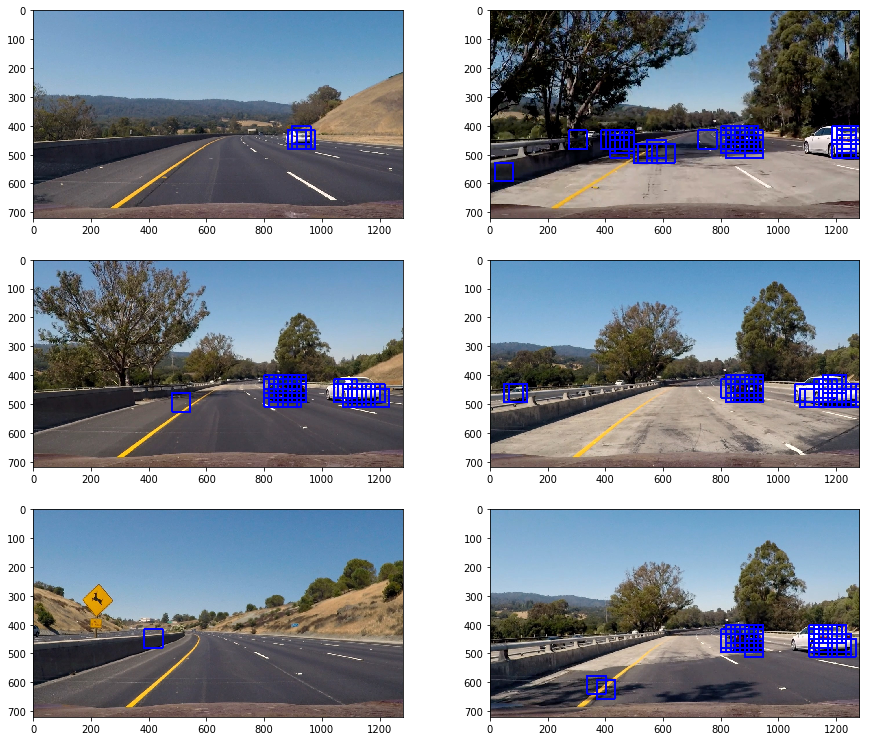

In [136]:
# Get scalar from our pickle file
f = open("scalar.pickle","rb")
scalar = pickle.load(f)
X_scalar = scalar['X_scalar']
f.close()
# Get test images
test_images = get_test_images('./test_images/*.jpg')
car_windows = []
car_images = []
# For each test image find the bounding boxes
for test_image in test_images:
    window = find_cars(test_image, y_start, y_stop, scale, svc, X_scalar, orient, pix_per_cell, cell_per_block, size, hist_bins)
    # Draw bounding boxes and save the images in car_images
    car_images.append(draw_boxes(test_image, window))
    # Save windows in car_windows
    car_windows.append(window)
# Plot the boxed test images
plot_images(car_images)

## Improvements

### Heatmap, Thresholding and draw labeled bounding boxes

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Add heatmap, threshold, label, draw bouding boxes and plot the test images

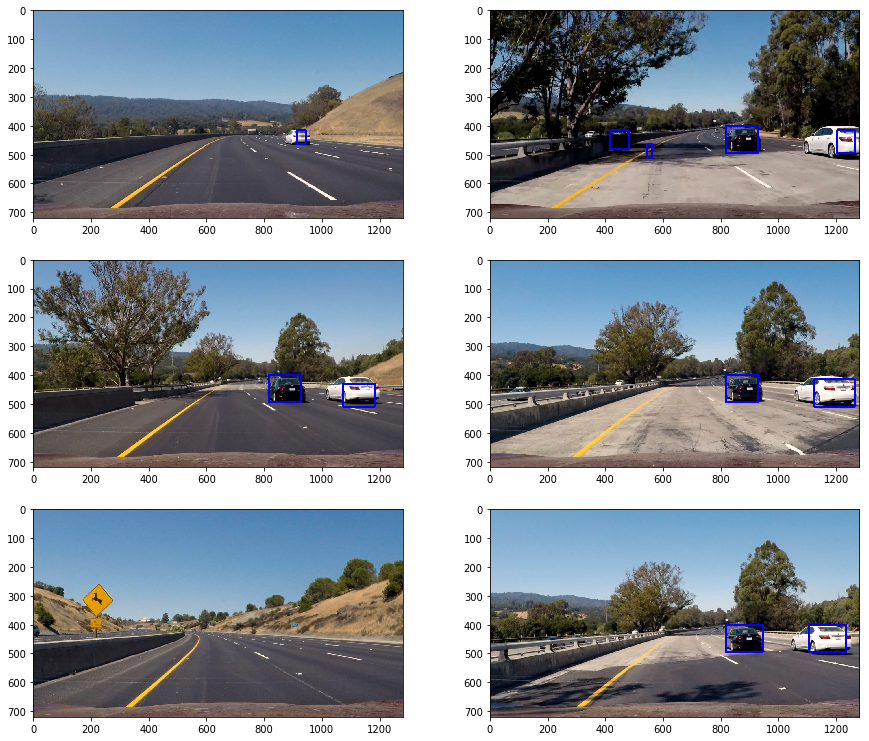

In [140]:
from scipy.ndimage.measurements import label
boxed_images = []

for i in range(6):
    heat = add_heat(np.zeros(test_images[i].shape), car_windows[i])
    heatmap = apply_threshold(heat, 3)
    labels = label(heatmap)
    boxed_images.append(draw_labeled_bboxes(test_images[i].copy(), labels))
         
plot_images(boxed_images)

### Window class
- Saves rectangles
- Deletes rectangles from frames older than 15

In [15]:
class Windows():
    def __init__(self):
        self.rects = []
        
    def push_rects(self, rects):
        # save rects
        self.rects.append(rects)
        # call to clean up older rects
        self.pop_rects()
        
    def pop_rects(self):
        rects_len = len(self.rects)
        # if rects older than 15, remove it
        if rects_len > 15:
            self.rects = self.rects[rects_len-15:]
            
    def peek_rects(self):
        return self.rects

### Video pipeline for testing

In [168]:
from moviepy.editor import VideoFileClip
scale  = 1
def DetectVehicle(img):
    # Obtain bounding boxes 
    car_rects = find_cars(img, y_start, y_stop, scale, svc, X_scalar, orient, pix_per_cell, cell_per_block, size, hist_bins)
    # Store the boxes in windows object
    if len(window) > 0:
        windows.push_rects(car_rects)
    
    heat_img = np.zeros(img.shape)
    # Get buffered rects from window object
    rects = windows.peek_rects()
    # for all boxes add heat 
    for rect in rects:
        heat = add_heat(heat_img, rect)
    # Threshold the heatmap
    heatmap = apply_threshold(heat, len(windows.peek_rects())*2)
    # Label the heatmap to get blobs (representing cars)
    labels = label(heatmap)
    # Return image with bounding box on labelled blobs
    return draw_labeled_bboxes(img.copy(), labels)

# Instantiate a Windows object
windows = Windows()
def pipeline(input_video, out_video_filename):
    """
    Get frames from the input_video and process it through the Detect_Vehicle function
    Write the output to a file out_video_filename
    """
    # Subset of the clip
    input_clip = VideoFileClip(input_video).subclip(41, 43)
#     input_clip = VideoFileClip(input_video)
    output_clip = input_clip.fl_image(DetectVehicle)
    output_clip.write_videofile(out_video_filename, audio = False, verbose=True, progress_bar=True)

pipeline('project_video.mp4', 'test0.mp4')    
# pipeline('project_video.mp4', 'output_video.mp4')

[MoviePy] >>>> Building video test0.mp4
[MoviePy] Writing video test0.mp4


 98%|█████████▊| 50/51 [02:16<00:02,  2.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test0.mp4 



### Improvements to further tackle false positives
- Use 32 bins (Need to generate feature set again and get a new X_scalar on AWS)
- Use multiple scale and respective y_start and y_stop set.

In [19]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
size = (16,16)
hist_bins = 32    # Earlier 24
window = (64,64)

### Run model again with new data, print accuracy

In [16]:
# Fetch pickle file generated with 32 bins histogram features
f = open("dataset32bins.pickle","rb")
# load dataset
dataset = pickle.load(f)
X_train,y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
# Run model
svc, accuracy = model(X_train,y_train, X_test, y_test)
X_scalar = dataset['X_scalar']
# Print accuracy
print('Test Accuracy: {:.4f}'.format(accuracy))

f.close()

/home/vinod/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Test Accuracy: 0.9900


### Generate bounding boxes for Multiple scale, y_start, y_stop set. Visualize with heatmap

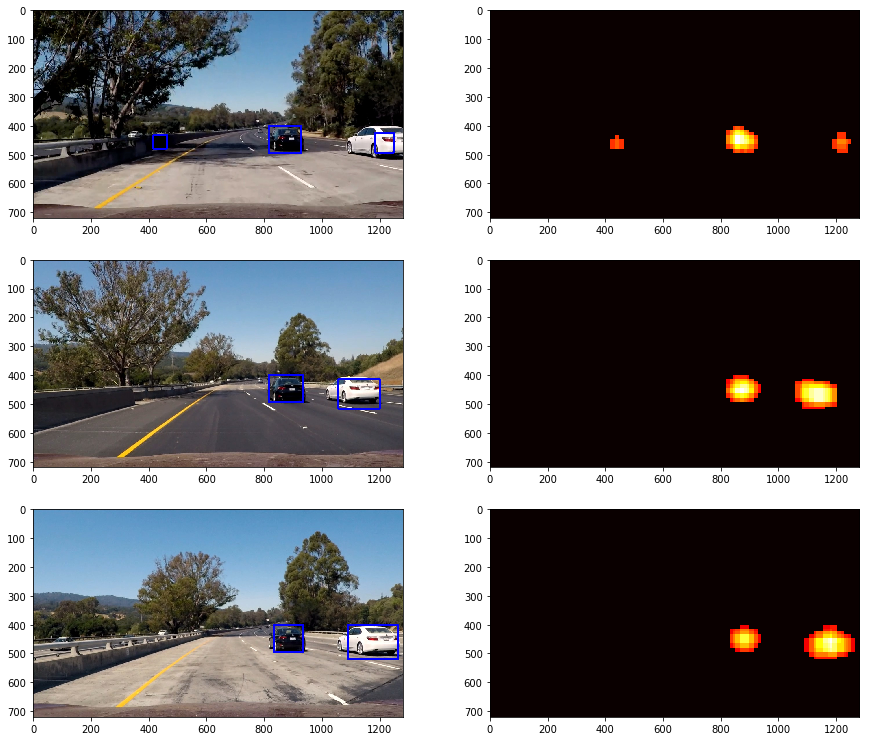

In [48]:
from scipy.ndimage.measurements import label
test_images = get_test_images('./test_images/*.jpg')
# Array of three values for y_start, y_stop and scale
ystarts_ystops = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]

boxed_images = []
# For test images 1- 4
for test_image in test_images[1:4]:
    windows = []
    # For all parameter set (y_start, y_stop and scale) 
    for (ystart, ystop, scale) in ystarts_ystops:
        # Obtain bounding boxes
        car_rects = find_cars(test_image, y_start, y_stop, scale, svc, X_scalar, orient, pix_per_cell, cell_per_block, size, hist_bins)
        if len(car_rects) > 0:
            windows.append(car_rects)
    
    img = np.zeros_like(test_image[:,:,0])
    # Add heat to all bounding boxes
    for rects in windows:
        heat = add_heat(img, rects)
    # Threshold the heatmap
    heatmap = apply_threshold(heat, len(windows)*2)
    # Label the heatmap to get blobs (representing cars)
    labels = label(heatmap)
    # Save labelled image
    boxed_images.append(draw_labeled_bboxes(test_image.copy(), labels))
    # save heatmaps
    boxed_images.append(heatmap)
# Plot images    
plot_images(boxed_images, cmapp= 'hot')

## 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

### Video Implementation
Combining bounding boxes from multiple frames and filtering for false positives.

In [39]:
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
# Array of three values for y_start, y_stop and scale
ystarts_ystops = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]

def DetectVehicle(img):
    # For all parameter set (y_start, y_stop and scale)
    for (ystart, ystop, scale) in ystarts_ystops:
        # Obtain bounding boxes
        car_rects = find_cars(img, y_start, y_stop, scale, svc, X_scalar, orient, pix_per_cell, cell_per_block, size, hist_bins)
        if len(car_rects) > 0:
            windows.push_rects(car_rects)
    # Blank heat image
    heat_img = np.zeros(img.shape)
    # Get buffered bounding boxes from windows object
    rects = windows.peek_rects()
    # Add heat to all bounding boxes
    for rect in rects:
        heat = add_heat(heat_img, rect)
    # Threshold the heatmap
    heatmap = apply_threshold(heat, len(windows.peek_rects())*2)
    # Label the heatmap to get blobs (representing cars)
    labels = label(heatmap)
    # Return image with bounding box on labelled blobs
    return draw_labeled_bboxes(img.copy(), labels)

# Instantiate a Windows object
windows = Windows()
def pipeline(input_video, out_video_filename):
    """
    Get frames from the input_video and process it through the Detect_Vehicle function
    Write the output to a file out_video_filename
    """
    input_clip = VideoFileClip(input_video)
    # Call DetectVehicle for each frame from the video clip
    output_clip = input_clip.fl_image(DetectVehicle)
    output_clip.write_videofile(out_video_filename, audio = False, verbose=True, progress_bar=True)
    
pipeline('project_video.mp4', 'output_video_32bins.mp4')

[MoviePy] >>>> Building video output_video_32bins.mp4
[MoviePy] Writing video output_video_32bins.mp4


100%|█████████▉| 1260/1261 [1:05:09<00:02,  2.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_32bins.mp4 



### Discussion

1. The challenging part of the project was dealing with False Positives. I had to play around with parameters quiet a lot. 
2. The current implementation uses HOG subsampling with multiple scales. This requires a lot of processing and is not suitable for real-time vehicle tracking without high end graphics cards(I assume). This is a great limitation.
3. The frames are a bit gittery and there are very few false positives. We cannot tolerate having false positives, especially closer to the car. This is a more critical limitation.
4. The dataset we trained our classifier is too small in size, too narrow in diversity and too close in lighting conditions. We need a better dataset to be able to generalise to different vehicles and tracks.
5. Our pipeline detects oncoming cars as well. I am not sure how the vehicle is supposed to understand that there is a barricade separation between it's lane and the opposite lane.
6. We may be able to get a more robust results using YOLO object detection algorithm.

The project was interesting. It helped understand concepts in traditional Computer Vision. It helped me imagine how it could potentially compliment deep learning algorithms. I appriciate Udacity team for bringing together